In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import Project_library as pl
import jax
import jax.numpy as jnp

In [6]:

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [
    'CMU Serif Roman',  # primary CMU serif face
    'Times New Roman',  # fallback
    'Georgia',
    'serif'
]
plt.rcParams['axes.grid'] = True
# 3. Set the global font size:
plt.rcParams['font.size'] = 14  # change this number to taste

# 4. (Optional) Adjust axes titles and labels separately if you like:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

### Illustrate the changes in demand


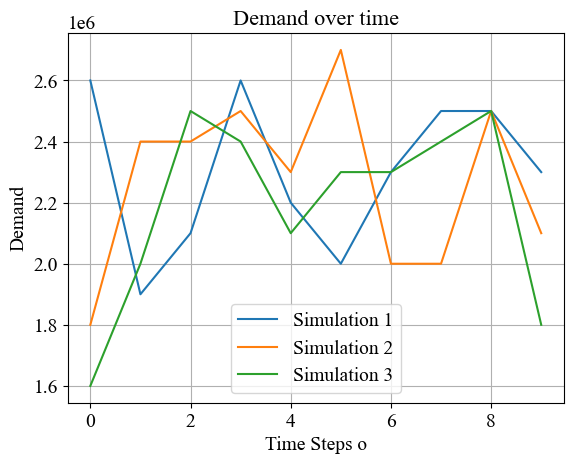

In [7]:
for x in range(1, 4):
    number_of_users = 30
    s = []

    key = jax.random.PRNGKey(x)

    for i in range(number_of_users):
        s.append(jax.random.choice(key, jax.numpy.asarray([0, 1]), shape=(1,), p=jax.numpy.asarray([0.3, 0.7])))
        subkey, key = jax.random.split(key)

    key = jax.random.split(key, (number_of_users,))

    s = jax.numpy.array(s)

    alpha = 0.7
    beta = 0.2

    A = jax.numpy.asarray([[1-alpha, alpha], [beta, 1-beta]])

    O = 10

    time_series = jax.numpy.zeros((number_of_users, O))

    s = s.reshape((number_of_users))

    demands = pl.users_state_change(A, s, time_series, key)

    demand_over_time = jax.numpy.sum(demands, axis=0)*100000
    plt.plot(demand_over_time, label=f"Simulation {x}")

plt.legend()
plt.title("Demand over time")
plt.xlabel("Time Steps o")
plt.ylabel("Demand")
plt.savefig("demand_over_time.pdf",  bbox_inches='tight')
plt.show()

### Illustrate different value emperically

[0 0 0 0 0 0 0 0]
[1.000e+00 7.000e+00 7.500e+01 4.760e+02 1.307e+03 2.569e+03 3.015e+03
 1.990e+03 5.600e+02]
[0 0 0 0 1 1 1 1]
[0.000e+00 3.000e+00 4.000e+01 2.180e+02 8.670e+02 2.113e+03 3.146e+03
 2.641e+03 9.720e+02]
[1 1 1 1 1 1 1 1]
[   0.    0.   15.   87.  431. 1416. 2979. 3411. 1661.]
[[1.000e+00 7.000e+00 7.500e+01 4.760e+02 1.307e+03 2.569e+03 3.015e+03
  1.990e+03 5.600e+02]
 [0.000e+00 3.000e+00 4.000e+01 2.180e+02 8.670e+02 2.113e+03 3.146e+03
  2.641e+03 9.720e+02]
 [0.000e+00 0.000e+00 1.500e+01 8.700e+01 4.310e+02 1.416e+03 2.979e+03
  3.411e+03 1.661e+03]]


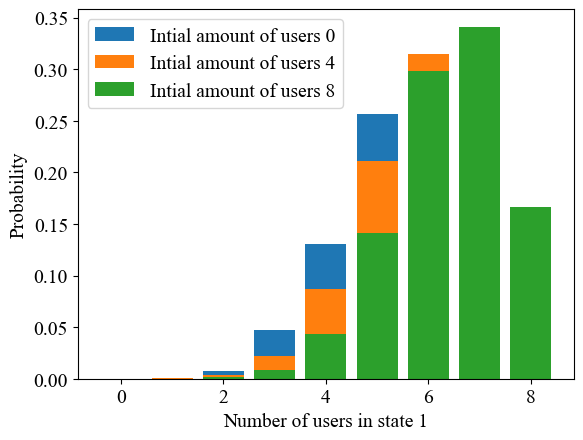

In [26]:


number_of_realizations = 10000

key = jax.random.PRNGKey(0)

users_states = jnp.array([[0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0],[1,1,0,0,0,0,0,0],[1,1,1,0,0,0,0,0],[0,0,0,0,1,1,1,1],[1,1,1,1,1,0,0,0], [1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0],  [1,1,1,1,1,1,1,1]]) 

users_states = users_states[jnp.asarray([0,4,8])]

intial_sum = jnp.sum(users_states)

time_series = jnp.zeros((users_states.shape[1],2))

outcome = jnp.zeros((users_states.shape[0],users_states.shape[1]+1))

# Now I want to run the simulation for a number of realizations with the same initial state
for k in range(outcome.shape[0]):
    print(users_states[k])
    for i in range(number_of_realizations):
        key = jax.random.split(key, (users_states.shape[1],))
        time_series = pl.users_state_change(A, users_states[k], time_series, key)
        # Okay now i sum up the time series for each time step 
        outcome = outcome.at[k,jnp.sum(time_series, axis=0)[1]].add(1)
        key = key[0]
    print(outcome[k])



print(outcome)
# Make a bar plot of the outcome normalized by the number of realizations
for i in range(outcome.shape[0]):
    plt.bar(jnp.arange(outcome.shape[1]), outcome[i]/number_of_realizations, label=f'Intial amount of users {jnp.sum(users_states[i])}')
plt.legend()
plt.xlabel('Number of users in state 1')
plt.ylabel('Probability')
#plt.title(f'Probability of users in state 1 after 1 time step given varying initial statse')
plt.grid()
plt.savefig("probability_of_users_in_different_states_after_one_step.pdf",  bbox_inches='tight')
plt.show()

#### Calculate the same value using binomial convolution

[6.5610118e-05 1.2247202e-03 1.0001883e-02 4.6675418e-02 1.3613668e-01
 2.5412175e-01 2.9647547e-01 1.9765036e-01 5.7648107e-02]
[1.2959986e-05 3.2831985e-04 3.6028805e-03 2.2362253e-02 8.5847251e-02
 2.0871435e-01 3.1385094e-01 2.6693621e-01 9.8344870e-02]
[2.5600027e-06 8.1919970e-05 1.1468795e-03 9.1750324e-03 4.5875158e-02
 1.4680052e-01 2.9360116e-01 3.3554438e-01 1.6777241e-01]


Text(0, 0.5, 'Probability')

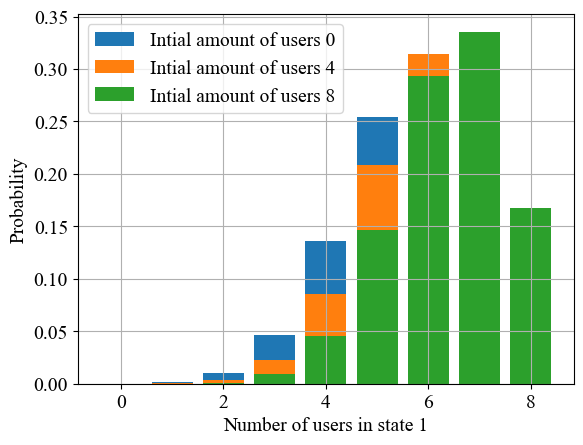

In [ ]:
active_users_in_state_one = jnp.sum(users_states, axis=1)
key = jax.random.PRNGKey(0)

M = users_states.shape[1]


for act_users in active_users_in_state_one:
    # Number of users in each state
    M1 = act_users
    M2 = M - M1

    k1 = jnp.arange(M1+1)
    k2 = jnp.arange(M2+1)


    # Binomial Distribution of each case
    Binom_from_on_to_on = jax.scipy.stats.binom.pmf(k1, n=M1,p=1-beta)
    Binom_from_off_to_on = jax.scipy.stats.binom.pmf(k2, n=M2, p=alpha)
    

    # Convolve the two distributions
    convolved = jax.scipy.signal.convolve(Binom_from_on_to_on, Binom_from_off_to_on, mode='full')


    # Normalize the convolved distribution
    convolved = convolved / jnp.sum(convolved)


    # Plot the convolved distribution bar plot
    plt.bar(jnp.arange(convolved.shape[0]), convolved, label=f'Intial amount of users {act_users}')

plt.legend()
plt.xlabel('Number of users in state 1')
plt.ylabel('Probability')
plt.savefig("probability_of_users_in_different_states_after_one_step_convolved.pdf",  bbox_inches='tight')